Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1
18000


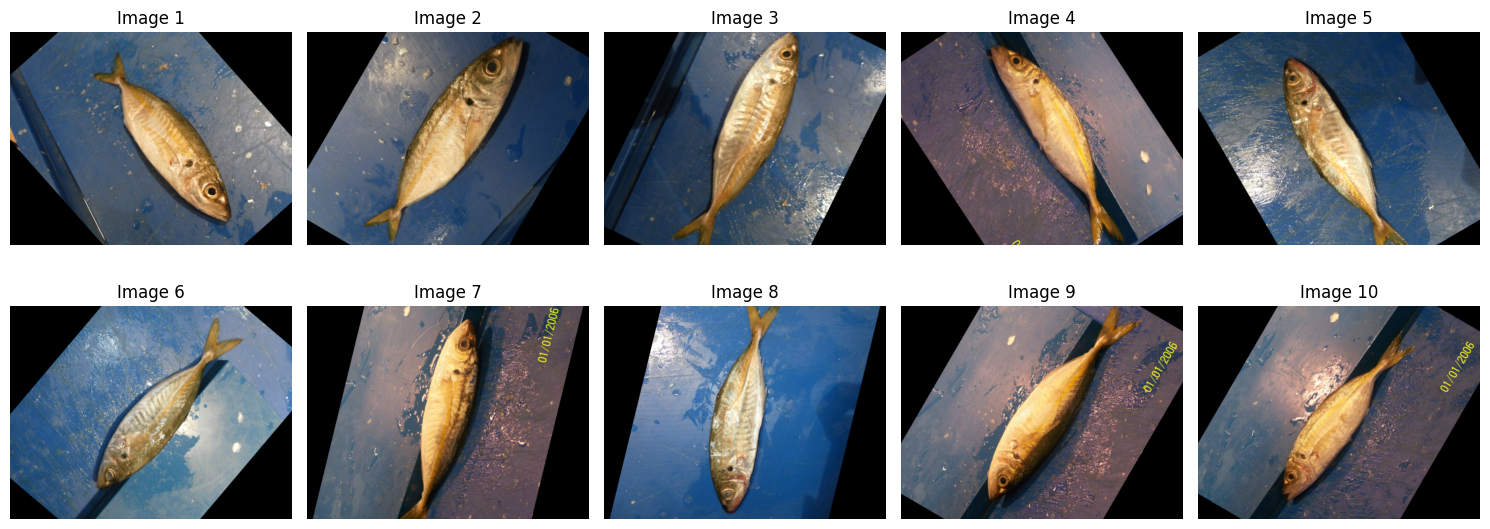

None


In [18]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)
from tensorflow.keras.layers import Flatten

from glob import glob
import random, os, datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model

from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

dir_path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

img_paths = get_image_paths(dir_path)
print(len(img_paths))
print(display_images(img_paths[0:10]))

In [19]:
# Veri seti hazırlanması

# Resimlerin boyutu
img_height, img_width = 128, 128
batch_size = 32

# Veri artırma ve veri setini yükleme için ImageDataGenerator kullanımı
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalleştirme
    shear_range=0.2,  # Şekil bozulmaları
    zoom_range=0.2,   # Zoom
    horizontal_flip=True,  # Yatay çevirme
    rotation_range=30,  # Döndürme ekledim
    brightness_range=[0.8, 1.2],  # Parlaklık artırma ekledim
    validation_split=0.2)  # Eğitim ve doğrulama veri seti bölme

# Eğitim veri seti
train_generator = train_datagen.flow_from_directory(
    dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # Eğitim için

# Doğrulama veri seti
validation_generator = train_datagen.flow_from_directory(
    dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # Doğrulama için

# Etiket sınıflarını ve toplam sınıf sayısını elde edelim
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print(f"Sınıflar: {class_labels}, Toplam sınıf sayısı: {num_classes}")


Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.
Sınıflar: ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout'], Toplam sınıf sayısı: 9


In [20]:
#Model oluşturma

In [21]:
# Modelin oluşturulması
model = Sequential()

# Giriş katmanı ve ilk gizli katman
model.add(Input(shape=(img_height, img_width, 3)))
model.add(Flatten())

# İlk gizli katman
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Nöron sayısını artırdık
model.add(BatchNormalization())
model.add(Dropout(0.5))

# İkinci gizli katman
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Nöron sayısını artırdık
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Üçüncü gizli katman
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Ek katman ekledik
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Dördüncü gizli katman
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Daha derin katman
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout oranı optimize edildi

# Çıkış katmanı
model.add(Dense(num_classes, activation='softmax'))

# Learning rate scheduler ekledim
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Modelin derlenmesi
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Öğrenme oranını manuel belirledik
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model özetini yazdıralım
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,343,241 (96.68 MB)

 Trainable params: 25,341,321 (96.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [22]:
# Modelin oluşturulması


In [23]:
# Eğitim

# Model callback'leri
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')  # .keras uzantısı kullanıldı
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model eğitimi
history = model.fit(
    train_generator,
    epochs=30,  # Epoch sayısını artırdım
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, lr_scheduler]  # lr_scheduler eklendi
)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 318s 692ms/step - accuracy: 0.1700 - loss: 4.4761 - val_accuracy: 0.1575 - val_loss: 3.2228 - learning_rate: 0.0010
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 313s 690ms/step - accuracy: 0.2321 - loss: 3.0083 - val_accuracy: 0.2022 - val_loss: 2.9127 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 311s 685ms/step - accuracy: 0.2557 - loss: 2.6344 - val_accuracy: 0.2047 - val_loss: 2.7503 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 313s 691ms/step - accuracy: 0.2864 - loss: 2.4946 - val_accuracy: 0.2003 - val_loss: 2.6667 - learning_rate: 0.0010
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 311s 687ms/step - accuracy: 0.2850 - loss: 2.3849 - val_accuracy: 0.2247 - val_loss: 2.5854 - learning_rate: 0.0010
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 310s 683ms/step - accuracy: 0.2903 - loss: 2.3114 - val_accuracy: 0.1853 - val_loss: 2.6457 - learning_rate: 0.0010
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 312s 688ms/step - accuracy: 0.2967 

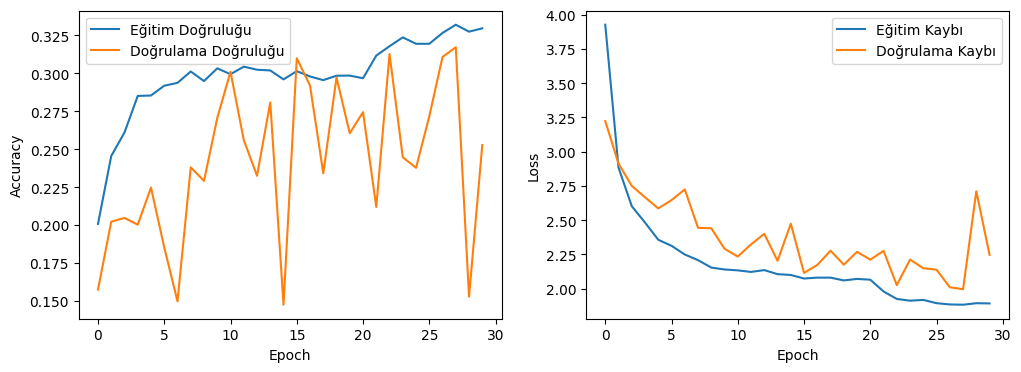

In [24]:
# Değerlendirme
# Eğitim sırasında kayıp ve doğruluk grafiği
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Test

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


Found 3600 images belonging to 9 classes.
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 526ms/step


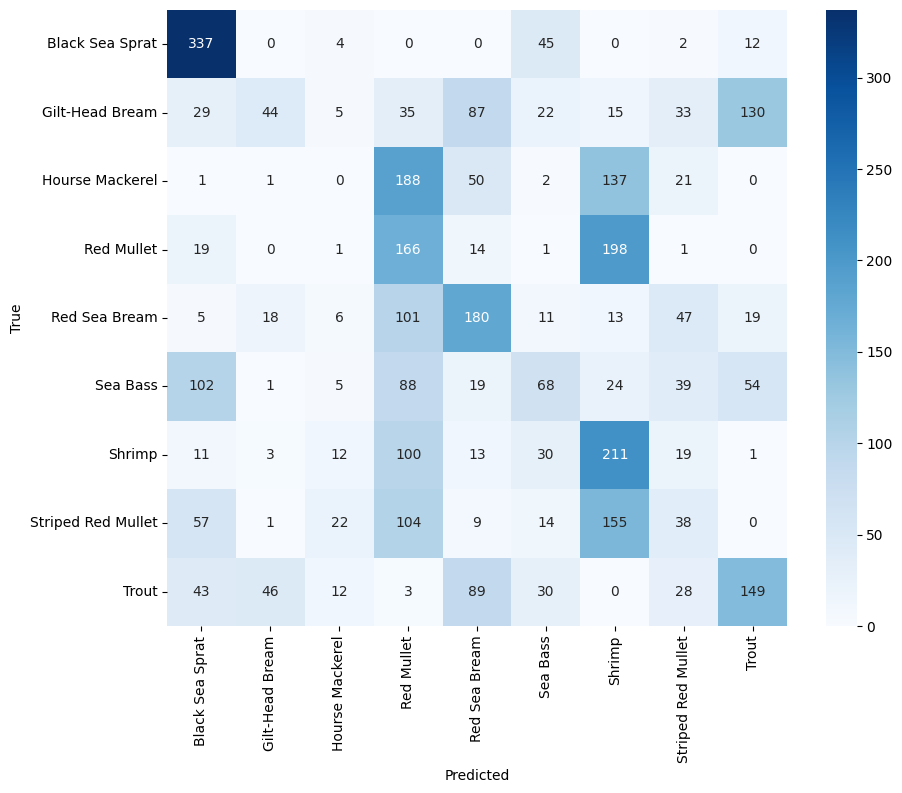

                    precision    recall  f1-score   support

   Black Sea Sprat       0.56      0.84      0.67       400
   Gilt-Head Bream       0.39      0.11      0.17       400
   Hourse Mackerel       0.00      0.00      0.00       400
        Red Mullet       0.21      0.41      0.28       400
     Red Sea Bream       0.39      0.45      0.42       400
          Sea Bass       0.30      0.17      0.22       400
            Shrimp       0.28      0.53      0.37       400
Striped Red Mullet       0.17      0.10      0.12       400
             Trout       0.41      0.37      0.39       400

          accuracy                           0.33      3600
         macro avg       0.30      0.33      0.29      3600
      weighted avg       0.30      0.33      0.29      3600



In [25]:
#Test

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Modeli test edelim
test_generator = train_datagen.flow_from_directory(
    dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Validation subset'i test için kullanıyoruz
    shuffle=False)

# Tahminler
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

In [26]:
# Test verisi üzerinden tahmin yapma
y_pred = model.predict(test_generator)

# Tahminlerin sınıf etiketlerine dönüştürülmesi
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketler
y_true = test_generator.classes

# Doğru tahmin sayısını bulma
correct_predictions = np.sum(y_pred_classes == y_true)

# Toplam test örneği sayısı
total_samples = len(y_true)

# Doğruluğun hesaplanması
accuracy = (correct_predictions / total_samples) * 100  # Yüzde olarak doğruluk

print(f"Model Doğruluğu: {accuracy:.2f}%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 520ms/step
Model Doğruluğu: 31.69%
